# Technical Test

## 1. Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve

## 2. Data Loading

In [2]:
# Load data
df = pd.read_csv('../data/credit_scoring.csv')
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


## 3. EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [4]:
# Cek row yang duplikat
df.duplicated().sum()

0

<Axes: >

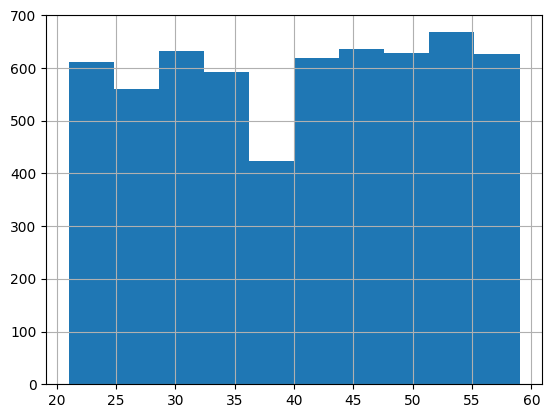

In [5]:
df['age'].hist()


<Axes: >

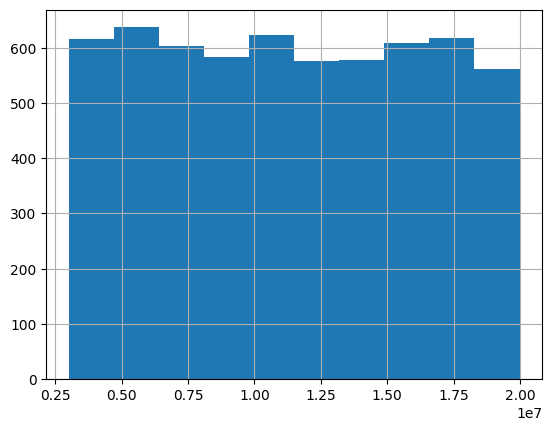

In [6]:
df['monthly_income'].hist()



<Axes: >

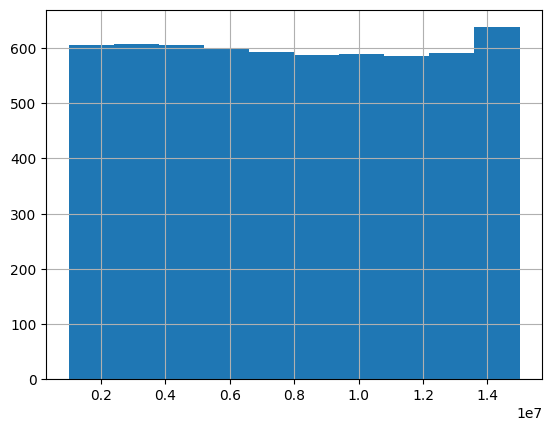

In [7]:
df['loan_amount'].hist()

In [8]:
# Drop kolom leak
df.drop(['leak_col_good', 'leak_col_subtle'],axis=1, inplace=True)
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0
5996,506996,40,9944385,4082038,1,477,0
5997,506997,28,9048532,14760384,0,450,0
5998,506998,51,6843160,11774594,0,561,0


Dari EDA yang telah dilakukan, ditemukan bahwa dataset tidak mengandung missing value, data duplikat, serta tipe datanya sudah sesuai.

Berdasarkan tiga histogram yang dianalisis:

* Rentang usia yang paling banyak mengajukan pinjaman berada di kisaran 50–55 tahun, yang termasuk dalam kategori pra-lansia.

* Sebagian besar pemohon memiliki pendapatan bulanan sekitar Rp5.000.000.

* Jumlah pinjaman yang paling sering diajukan adalah sebesar Rp14.000.000.

## 4. Feature Engineering

### A. Split X dan y

In [9]:
X = df.drop(['application_id', 'default'], axis=1)
y = df.default

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 40)
print('Train Size:', X_train.shape)
print('Train Size:', X_test.shape)

Train Size: (4800, 5)
Train Size: (1200, 5)


### B. Handling Outlier

In [10]:
# skewness test untuk melihat apakah data terdistribusi normal atau skew
skew_test = ['age', 'monthly_income', 'loan_amount', 'credit_score']

for i in skew_test:
    hasil = X_train[i].skew()
    
    print(f'Distribusi kolom {i}: {hasil}')

Distribusi kolom age: -0.06345363146474678
Distribusi kolom monthly_income: 0.014424094320501355
Distribusi kolom loan_amount: 0.003237744086270139
Distribusi kolom credit_score: -0.024777358852267218


Dari hasil skew test menunjukkan bahwa semua kolom terdistribusi normal, karena nilainya yang mendekati 0

## 5. Modelling

### A. Membuat Pipeline

In [11]:
# Make Pipeline
pipe_log = make_pipeline(StandardScaler(),LogisticRegression(max_iter=100))
pipe_gradboost = make_pipeline(StandardScaler(),GradientBoostingClassifier())

### B. Cross Validation

In [12]:
# Setting kfold
skfold = StratifiedKFold(n_splits=5)

# Define Cross Validation
cv_log_model = cross_val_score(pipe_log, X_train, y_train, cv= skfold, scoring='roc_auc', n_jobs=-1)
cv_gradboost_model = cross_val_score(pipe_gradboost, X_train, y_train, cv= skfold, scoring='roc_auc', n_jobs=-1)

In [13]:
# Finding Best Model based on Cross_Val_Score (mean)
name_model = []
cv_scores = 0
for cv,name in zip([cv_log_model,cv_gradboost_model],
                   ['log_model','gradboost_model']):
  print(name)
  print('roc_auc - All - Cross Validation :', cv)
  print('roc_auc - Mean - Cross Validation :', cv.mean())
  print('roc_auc - std - Cross Validation :', cv.std())
  print('roc_auc - Range of Test Set :', (cv.mean()-cv.std()), '-' , (cv.mean()+cv.std()))
  print('-'*50)
  if cv.mean() > cv_scores:
    cv_scores = cv.mean()
    name_model = name
  else:
    pass
print('Best Model:', name_model)
print('Cross Val Mean from Best Model:', cv_scores)

log_model
roc_auc - All - Cross Validation : [0.87268895 0.73474471 0.73349938 0.79509494 0.79078762]
roc_auc - Mean - Cross Validation : 0.7853631198676283
roc_auc - std - Cross Validation : 0.05099412991761438
roc_auc - Range of Test Set : 0.7343689899500139 - 0.8363572497852427
--------------------------------------------------
gradboost_model
roc_auc - All - Cross Validation : [0.78695277 0.5319954  0.67108918 0.75927391 0.69883966]
roc_auc - Mean - Cross Validation : 0.6896301864667133
roc_auc - std - Cross Validation : 0.08899353081456675
roc_auc - Range of Test Set : 0.6006366556521465 - 0.77862371728128
--------------------------------------------------
Best Model: log_model
Cross Val Mean from Best Model: 0.7853631198676283


### C. Hyper parameter

In [14]:
param_logreg = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [0.01, 0.1, 1, 10],
    'logisticregression__solver': ['lbfgs', 'liblinear'],
    'logisticregression__class_weight': [None, 'balanced']
}

grid_logreg = GridSearchCV(pipe_log, param_logreg, cv=skfold, scoring='roc_auc')
grid_logreg.fit(X_train, y_train)

print("Best parameters:", grid_logreg.best_params_)
print("Best score:", grid_logreg.best_score_)

Best parameters: {'logisticregression__C': 0.1, 'logisticregression__class_weight': None, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best score: 0.7868334004973507


In [15]:
param_gradboost = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1],
    'gradientboostingclassifier__max_depth': [3, 5],
    'gradientboostingclassifier__subsample': [0.8, 1.0],
    'gradientboostingclassifier__min_samples_split': [2, 5],
    'gradientboostingclassifier__min_samples_leaf': [1, 3]
}

grid_gradboost = GridSearchCV(pipe_gradboost, param_gradboost, cv=5, scoring='accuracy')
grid_gradboost.fit(X_train, y_train)

print("Best parameters:", grid_gradboost.best_params_)
print("Best score:", grid_gradboost.best_score_)

best_gradboost = grid_gradboost.best_estimator_

Best parameters: {'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_leaf': 3, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__subsample': 0.8}
Best score: 0.9879166666666667


Hasil dari cross validation menunjukkan bahwa best model untuk dataset ini adalah Logistic Regression dengan nilai mean mencapai 0.78, nilai mean yang tiinggi menunjukkan model yang lebih konsisten dan resiko overfit lebih kecil.

Tetapi setelah dilakukan hyper parameter tuning, Gradientboost menunjukkan hasil score yang lebih tinggi dibandingkan hasil score dari logistic regression dengan score 0.987. Maka saya memutuskan menggunakan model Gradient Boost untuk membuat machine learning ini

### D. Model Predict & Evaluation

In [16]:
y_pred_train = best_gradboost.predict(X_train)
y_pred_train = best_gradboost.predict(X_train)

In [17]:
y_train_proba = best_gradboost.predict_proba(X_train)[:,1]
y_test_proba = best_gradboost.predict_proba(X_test)[:,1]

roc_auc_train_gradboost = roc_auc_score(y_train,y_train_proba)
roc_auc_test_gradboost = roc_auc_score(y_test,y_test_proba)

print(f"Roc Auc (train): {roc_auc_train_gradboost:.4f}")
print(f"Roc Auc (test): {roc_auc_test_gradboost:.4f}")

Roc Auc (train): 0.9884
Roc Auc (test): 0.8750


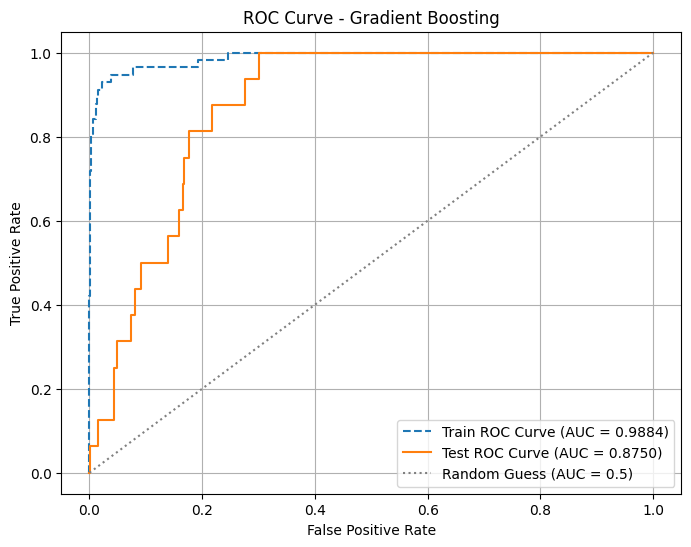

In [18]:
# Membuat ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC Curve (AUC = {roc_auc_train_gradboost:.4f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC Curve (AUC = {roc_auc_test_gradboost:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Guess (AUC = 0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Berdasarkan dari kurva ROC, model gradient boosting menunjukkan performa klasifikasi yang sangat baik hal ini ditunjukkan dari hasil AUC pada data train yang sangat tinggi yaitu 0.9394, yang berarti model mampu membedakan antara kelas true dan false dengan sangat baik.

Pada data testnyapun nilai AUC nya tidak berbeda jauh dengan data train yaitu 0.8960. Ini menunjukkan bahwa model memiliki kemampuan generalisasi yang baik dan tidak mengalami overfitting.

Secara keseluruhan halis dari kurva ROC dan nilai AUC menunjukkan  moderadient boosting memiliki performa yang baik pada data train maupun data test, dan model ini juga dapat digunuakan di dunia nyata dengan persentase keberhasilan yang tinggi atau dapat dipercaya

### E. Scorecard

In [19]:
# Fungsi scorecard
def prob_to_score(p, base_score=600, pdo=50, odds_base=1):
    p = np.clip(p, 1e-6, 1 - 1e-6)  
    B = pdo / np.log(2)
    A = base_score + B * np.log(odds_base)
    odds = (1 - p) / p 
    score = A + B * np.log(odds)
    return np.clip(score, 300, 850) 

# Fungsi risk level
def assign_risk(score):
    if score < 580:
        return 'High Risk'
    elif score <= 680:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Score Credit
train_scores = prob_to_score(y_train_proba)
test_scores = prob_to_score(y_test_proba)

# Risk level
train_risks = [assign_risk(score) for score in train_scores]
test_risks = [assign_risk(score) for score in test_scores]

In [20]:
# Menggabungkan dengan X,y,credit score, dan risk level
train_full = X_train.copy()
train_full['default'] = y_train
train_full['credit_score'] = train_scores
train_full['risk_level'] = train_risks

test_full = X_test.copy()
test_full['default'] = y_test
test_full['credit_score'] = test_scores
test_full['risk_level'] = test_risks

df_all_scores = pd.concat([train_full, test_full], axis=0).reset_index(drop=True)
df_all_scores

,age,monthly_income,loan_amount,previous_defaults,credit_score,default,risk_level
0,57,4446124,11914789,0,850.000000,0,Low Risk
1,27,5917114,11501508,0,850.000000,0,Low Risk
2,35,19762447,9609715,1,850.000000,0,Low Risk
3,27,13498233,7994906,0,850.000000,0,Low Risk
4,42,3417319,7933622,1,850.000000,0,Low Risk
...,...,...,...,...,...,...,...
5995,51,5973392,10526994,0,850.000000,0,Low Risk
5996,46,5561269,7719233,0,850.000000,0,Low Risk
5997,26,13052692,14548282,1,850.000000,0,Low Risk
5998,27,11574770,10952905,2,850.000000,0,Low Risk


### F. SHAP

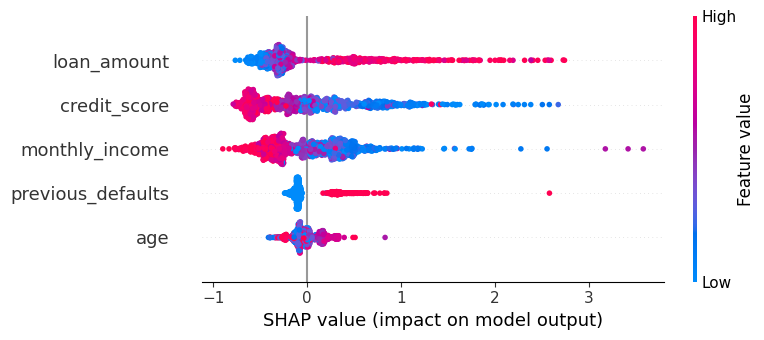

In [21]:
explainer = shap.Explainer(best_gradboost.named_steps['gradientboostingclassifier'])
X_test_transformed = best_gradboost.named_steps['standardscaler'].transform(X_test)
shap_values = explainer(X_test_transformed)

# Generate SHAP summary plot dan simpan sebagai PNG
plt.figure()
shap.summary_plot(shap_values, X_test, max_display=10, show=False)
plt.tight_layout()
plt.savefig("shap_top10_features.png", dpi=300)
plt.show()

### G. Ekspor Data actual dan proba

In [22]:
predic = pd.DataFrame({
    'actual': y_test,
    'proba': y_test_proba
})

predic.to_csv("../data/predictions.csv", index=False)